In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid

import os
from tqdm.notebook import trange, tqdm
from skimage import io, transform

from datetime import datetime
import time

from copy import copy


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import keras as keras


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, TimeSeriesSplit, RandomizedSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.base import clone
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, make_scorer
from sklearn.svm import LinearSVC
import datetime

# Regression

In [ ]:
df = pd.read_excel("drive/MyDrive/training/HW/data/AirQualityUCI.xlsx")
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
9353,2005-04-04,11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
9354,2005-04-04,12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
9355,2005-04-04,13:00:00,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


## Data Preprocessing

Al the preprocessing from regression hw.

In [ ]:
columns_titles = ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH','C6H6(GT)']
df=df.reindex(columns=columns_titles)
df.rename(columns={'C6H6(GT)' : 'y'}, inplace=True)

* Set NaNs

In [ ]:
df[df == -200] = np.NaN

* Drop some features

In [ ]:
df.drop(['NMHC(GT)'], inplace=True, axis=1)
df.drop(['PT08.S2(NMHC)'], inplace=True, axis=1)

* Drop missing target values.

In [ ]:
df.dropna(subset=['y'], how='any', axis=0, inplace=True)

In [ ]:
order = list()
for i in range(24):
  order.append(datetime.time(i, 0))

mapper = dict(zip(order, range(24)))
df['time'] = df.Time.map(mapper)
df['weekday'] = df.Date.dt.weekday

* Filling missing values

In [ ]:
df_missed = df.interpolate(limit_direction='forward')

* Train/Test split

In [ ]:
threshold_train = round(df.shape[0] * 0.7)

train = df_missed.drop(['Date', 'Time'], axis=1).iloc[:threshold_train]
test = df_missed.drop(['Date', 'Time'], axis=1).iloc[threshold_train:]

In [ ]:
train

,CO(GT),PT08.S1(CO),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,y,time,weekday
0,2.6,1360.00,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754,11.881723,18,2
1,2.0,1292.25,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487,9.397165,19,2
2,2.2,1402.00,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239,8.997817,20,2
3,2.2,1375.50,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713,9.228796,21,2
4,1.6,1272.25,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794,6.518224,22,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6437,3.4,1269.50,542.0,586.25,101.0,1528.25,1290.00,13.100,78.700001,1.181744,13.996181,23,4
6438,3.5,1257.00,577.0,592.00,94.0,1520.00,1287.00,12.625,78.400002,1.141883,13.742933,0,5
6439,3.2,1245.75,568.0,621.00,99.0,1461.50,1234.50,12.750,77.900002,1.143753,12.794194,1,5
6440,2.9,1166.25,451.0,643.00,90.0,1408.00,1143.75,12.125,79.425001,1.120146,10.956517,2,5


* Removing outliers

In [ ]:
train_out = train

q1 = dict()
q2 = dict()
iqr = dict()

for col in train.columns[:-3]:
  q1[col] = train[col].quantile(0.25)
  q2[col] = train[col].quantile(0.75)
  iqr[col] = q2[col] - q1[col]

for col in train.columns[:-3]:
  train_out = train_out[~((train_out[col] < q1[col]-1.5*iqr[col] ) | (train_out[col] > q2[col]+1.5*iqr[col]))]
  
train_out.shape

(5608, 13)

In [ ]:
train_out = train_out[~((train_out['y'] > 30))]

* Data scaling and transformations

In [ ]:
NUMERICAL_POWER_TRANS = [ 'NOx(GT)', 'PT08.S5(O3)']
NUMERICAL_NO_TRANS = ['PT08.S1(CO)', 'T', 'RH', 'PT08.S4(NO2)']
CATEGORICAL = ['weekday', 'time']
target = ['y']

In [ ]:
def make_mapper(num_pow_trans, num_std_scaler, categorical):
  
  numerical_pow_def = gen_features(
      columns=[[c] for c in num_pow_trans],
      classes=[
          {'class': PowerTransformer}
      ]
  )

  numerical_scaler_def = gen_features(
      columns=[[c] for c in num_std_scaler],
      classes=[
          {'class': StandardScaler}
      ]
  )

  categorical_def = gen_features(
      columns=[[c] for c in categorical],
      classes=[
          {'class': OneHotEncoder}
      ]    
  )
  features = numerical_pow_def + numerical_scaler_def  + categorical_def
  mapper = DataFrameMapper(features)

  return mapper, features

* Function for model evaluation

In [ ]:
def evaluate_model(train, val, tr_y, val_y, pipeline):
    pipeline.fit(train, tr_y)
    pred_val = pipeline.predict(val)
    pred_train = pipeline.predict(train)
    mapper = pipeline.named_steps['mapper']

    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))], 
        'train_R2': [r2_score(tr_y, pred_train)],
        'val_RMSE': [np.sqrt(mean_squared_error(val_y, pred_val))],
        'val_R2': [r2_score(val_y, pred_val)]
    }), mapper.transformed_names_

* Final train/test split

In [ ]:
X_train, X_test = train_out.drop('y', axis=1), test.drop('y', axis=1)
y_train, y_test = train_out['y'], test['y']


pt = PowerTransformer()
minmax = MinMaxScaler()

y_train = minmax.fit_transform(
    pt.fit_transform(np.array(y_train).reshape(-1, 1))
)

y_test = minmax.transform(
    pt.transform(np.array(y_test).reshape(-1, 1))
)

## Previous best model for regression
(according to the previous homework: https://colab.research.google.com/drive/1LVT3E4zyhgrDg41Z3QGPLJxgq0zc475O#scrollTo=NP_dLss39k-E)

There were some issues, so the model is not perfect.

In [ ]:
mapper, features = make_mapper(NUMERICAL_POWER_TRANS, NUMERICAL_NO_TRANS, CATEGORICAL)
pipeline = Pipeline([
  ('mapper', DataFrameMapper(features)),
  ('estimator', LinearRegression())
])
scores, _ = evaluate_model(X_train, X_test, y_train, y_test, pipeline)
scores

,train_RMSE,train_R2,val_RMSE,val_R2
0,0.048308,0.94531,0.052118,0.955013


## Neural Network

In [ ]:
X_train_, X_test_ = mapper.fit_transform(X_train), mapper.transform(X_test)

In [ ]:
X_train_.shape

(5594, 37)

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu',))
model.add(Dense(32, activation='relu',))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=keras.optimizers.adam_v2.Adam(learning_rate=0.00012), loss='mse', metrics=['mae'])

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True)

In [ ]:
history = model.fit(X_train_, 
                    y_train, 
                    epochs=300, 
                    validation_split=0.1, 
                    verbose=2,
                    batch_size=32,
                    callbacks=[model_checkpoint_callback]
                    )

Epoch 1/300
158/158 - 1s - loss: 0.0126 - mae: 0.0881 - val_loss: 0.0072 - val_mae: 0.0681
Epoch 2/300
158/158 - 0s - loss: 0.0043 - mae: 0.0512 - val_loss: 0.0043 - val_mae: 0.0519
Epoch 3/300
158/158 - 0s - loss: 0.0033 - mae: 0.0452 - val_loss: 0.0047 - val_mae: 0.0554
Epoch 4/300
158/158 - 0s - loss: 0.0028 - mae: 0.0414 - val_loss: 0.0048 - val_mae: 0.0569
Epoch 5/300
158/158 - 0s - loss: 0.0024 - mae: 0.0388 - val_loss: 0.0051 - val_mae: 0.0592
Epoch 6/300
158/158 - 0s - loss: 0.0022 - mae: 0.0370 - val_loss: 0.0051 - val_mae: 0.0589
Epoch 7/300
158/158 - 0s - loss: 0.0021 - mae: 0.0356 - val_loss: 0.0053 - val_mae: 0.0601
Epoch 8/300
158/158 - 0s - loss: 0.0019 - mae: 0.0344 - val_loss: 0.0051 - val_mae: 0.0592
Epoch 9/300
158/158 - 0s - loss: 0.0018 - mae: 0.0336 - val_loss: 0.0050 - val_mae: 0.0585
Epoch 10/300
158/158 - 0s - loss: 0.0018 - mae: 0.0329 - val_loss: 0.0049 - val_mae: 0.0579
Epoch 11/300
158/158 - 0s - loss: 0.0017 - mae: 0.0323 - val_loss: 0.0047 - val_mae: 0.05

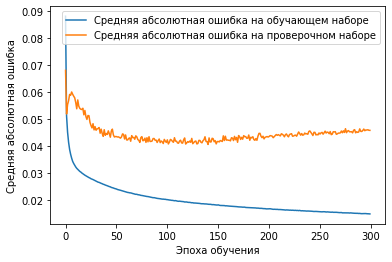

In [ ]:
# Считаем графики ошибки
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)
y_pred = model.predict(X_test_)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

RMSE: 0.06025703181050204
R2: 0.9398655544553166


Some insights:

* NN showed good results, but worse, than the best model from the previous homework

* NN predicted a little bit randomly, so the results were random (R2: 0.93-0.94)

* It is harder to tune parameters for NNs

# Classification

## Data Preprocessing

In [ ]:
def conf_matrix(y_true, y_pred, target_names):
  conf = confusion_matrix(y_true, y_pred)
  print(conf)
  sns.heatmap(conf,
              annot=conf/np.sum(conf, axis=1)[:, np.newaxis], #normalized by true class sizes
              yticklabels=target_names,
              xticklabels=target_names,
              cmap='bwr');
  plt.title('Regression confusion matrix');
  plt.xlabel('Predicted label');
  plt.ylabel('True label');

In [ ]:
df_cls = pd.read_csv("drive/MyDrive/training/HW/data/dataset_57_hypothyroid.csv", sep=",",  na_values = "?")
df_cls

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.30,t,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.10,t,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,F,f,f,f,f,f,f,f,f,f,f,f,t,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,negative
3768,68.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.00,t,2.1,t,124.0,t,1.08,t,114.0,f,NaN,SVI,negative
3769,74.0,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,t,5.10,t,1.8,t,112.0,t,1.07,t,105.0,f,NaN,other,negative
3770,72.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.70,t,2.0,t,82.0,t,0.94,t,87.0,f,NaN,SVI,negative


In [ ]:
df_cls.drop('referral_source', axis=1, inplace=True)
df_cls.drop(["TBG", "TBG_measured"], axis=1, inplace=True)

In [ ]:
CATEGORICAL = df_cls.select_dtypes(include=['object']).columns.tolist()
CATEGORICAL.remove('Class')
NUMERICAL = df_cls.select_dtypes(exclude=['object']).columns.tolist()
TARGET = 'Class'

In [ ]:
df_cls = df_cls[~(df_cls.Class == 'secondary_hypothyroid')]

In [ ]:
mapper = {
    'negative': 'neg',
    'compensated_hypothyroid': 'ch',
    'primary_hypothyroid': 'ph',
}
df_cls.Class = df_cls.Class.map(mapper)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df_cls.loc[df_cls.age == 455, 'age'] = 45

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
CATEGORICAL = ['sex','on_thyroxine','query_on_thyroxine','on_antithyroid_medication','sick','pregnant','thyroid_surgery',
               'I131_treatment','query_hypothyroid','query_hyperthyroid','lithium','goitre','tumor',
               'psych','TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured']


NUMERICAL = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
TARGET = 'Class'
BINARY = ['sex'] + [col for col in CATEGORICAL if len(df_cls[col].unique()) == 2]
BINARY

['sex',
 'on_thyroxine',
 'query_on_thyroxine',
 'on_antithyroid_medication',
 'sick',
 'pregnant',
 'thyroid_surgery',
 'I131_treatment',
 'query_hypothyroid',
 'query_hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'psych',
 'TSH_measured',
 'T3_measured',
 'TT4_measured',
 'T4U_measured',
 'FTI_measured']

In [ ]:
numerical_def = gen_features(
    columns=[[c] for c in NUMERICAL],
    classes=[
        {'class': SimpleImputer, 'strategy': 'median'},
        {'class': PowerTransformer}
    ]
)
# SimpleImputer, 'strategy': 'median'

bin_def = gen_features(
    columns=[[c] for c in BINARY],
    classes=[
        {'class': SimpleImputer, 'strategy': 'most_frequent'},
        {'class': OrdinalEncoder}
    ]
)

In [ ]:
features = numerical_def + bin_def

In [ ]:
target_names = ['neg', 'ch', 'ph']
mapper_y = {
    'neg': 0,
    'ch': 1, 
    'ph': 2,
}
y = df_cls.Class.map(mapper_y)
y

0       0
1       0
2       0
3       0
4       0
       ..
3767    0
3768    0
3769    0
3770    0
3771    0
Name: Class, Length: 3770, dtype: int64

## Previous best model for classification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_cls.drop('Class', axis=1), y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

In [ ]:
pipeline = Pipeline([
    ('mapper', DataFrameMapper(features)),
    ('feature_selection', SelectFromModel(LinearSVC(C=0.17777, penalty="l1", dual=False, random_state=42, max_iter=10000))),
])

In [ ]:
X_train_ = pipeline.fit_transform(X_train, y_train)
X_test_ = pipeline.transform(X_test)

In [ ]:
X_train_.shape

(2639, 17)

In [ ]:
rf = RandomForestClassifier(random_state=42, **{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 200})
rf.fit(X_train_, y_train)
y_pred = rf.predict(X_test_)
y_pred_train = rf.predict(X_train_)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1044
           1       0.98      0.98      0.98        58
           2       0.93      0.97      0.95        29

    accuracy                           1.00      1131
   macro avg       0.97      0.98      0.98      1131
weighted avg       1.00      1.00      1.00      1131



In [ ]:
print(f1_score(y_train, y_pred_train, average='macro'))
print(f1_score(y_test, y_pred, average='macro'))

0.9987105946473892
0.9771440021261003


## Neural Network

Data is imbalanced, so we should apply some methods to treat this issue.  We choose f1 as the main metric. Also, we can set class weights in optimizer.

In [ ]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
lb = LabelBinarizer()
y_train_ = lb.fit_transform(y_train)
y_test_ = lb.transform(y_test)

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

In [ ]:
class_weight

array([ 0.36096293,  6.46813725, 13.32828283])

In [ ]:
class_weight = {0: 0.36096293,
                1: 6.46813725,
                2: 13.32828283}

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu',))
model.add(Dense(32, activation='relu',))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu',))
model.add(Dense(32, activation='relu',))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(optimizer=keras.optimizers.adam_v2.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=[f1])

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_f1',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(
    X_train_, 
    y_train_, 
    epochs=150, 
    validation_split=0.1, 
    verbose=2,
    batch_size=32,
    callbacks=[model_checkpoint_callback],
    class_weight=class_weight,
)

Epoch 1/150
75/75 - 1s - loss: 0.8647 - f1: 0.4224 - val_loss: 0.4016 - val_f1: 0.8577
Epoch 2/150
75/75 - 0s - loss: 0.4218 - f1: 0.8900 - val_loss: 0.2397 - val_f1: 0.9034
Epoch 3/150
75/75 - 0s - loss: 0.2451 - f1: 0.9261 - val_loss: 0.1361 - val_f1: 0.9444
Epoch 4/150
75/75 - 0s - loss: 0.1851 - f1: 0.9366 - val_loss: 0.1409 - val_f1: 0.9444
Epoch 5/150
75/75 - 0s - loss: 0.1554 - f1: 0.9534 - val_loss: 0.1227 - val_f1: 0.9479
Epoch 6/150
75/75 - 0s - loss: 0.1459 - f1: 0.9512 - val_loss: 0.1265 - val_f1: 0.9479
Epoch 7/150
75/75 - 0s - loss: 0.1339 - f1: 0.9493 - val_loss: 0.1352 - val_f1: 0.9479
Epoch 8/150
75/75 - 0s - loss: 0.1227 - f1: 0.9516 - val_loss: 0.1714 - val_f1: 0.9479
Epoch 9/150
75/75 - 0s - loss: 0.1052 - f1: 0.9616 - val_loss: 0.1038 - val_f1: 0.9618
Epoch 10/150
75/75 - 0s - loss: 0.0839 - f1: 0.9597 - val_loss: 0.1412 - val_f1: 0.9514
Epoch 11/150
75/75 - 0s - loss: 0.0808 - f1: 0.9594 - val_loss: 0.1137 - val_f1: 0.9618
Epoch 12/150
75/75 - 0s - loss: 0.0660 - 

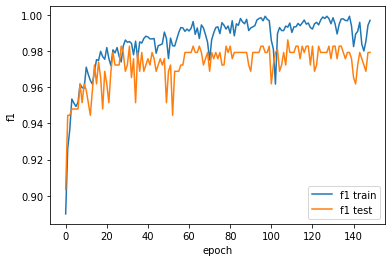

In [ ]:

plt.plot(history.history['f1'][1:], 
         label='f1 train')
plt.plot(history.history['val_f1'][1:], 
         label='f1 test')
plt.xlabel('epoch')
plt.ylabel('f1')
plt.legend()
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)
y_pred = lb.inverse_transform(model.predict(X_test_)).reshape(-1, 1)

print(f1_score(y_test, y_pred, average='macro'))

0.8930544075142565


[[1034    5    5]
 [   8   48    2]
 [   1    2   26]]


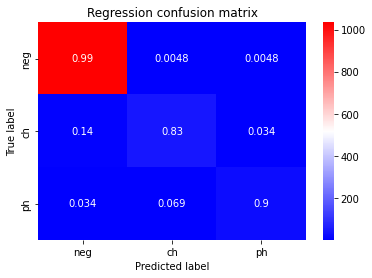

In [ ]:
conf_matrix(y_test, y_pred, target_names)

Some insights:

* The results obtained using NN are significantly worse than using Random Forest

# Image Classification

## Data Loading and Augmentation

Firstly, we need to create image dataset. We can set transformations, which will be applied to each image.

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset_train = ImageFolder('/content/drive/MyDrive/data/hotdogs/train')
test = ImageFolder('/content/drive/MyDrive/data/hotdogs/test', transform=transform_test)

In [ ]:
test.class_to_idx

{'hot_dog': 0, 'not_hot_dog': 1}

Secondly, we should divide our training data into training and validation. Augmentations should be applied to training set.

In [ ]:
train_size = int(dataset_train.__len__()*0.8)
val_size = dataset_train.__len__() - train_size

train, val = torch.utils.data.random_split(dataset_train, [train_size, val_size])
train.dataset = copy(dataset_train)

val.dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train.dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Let's overview some images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


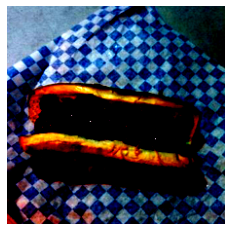

In [ ]:
print(test[11][1])
plt.imshow(test[11][0].squeeze().permute(1,2,0))
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


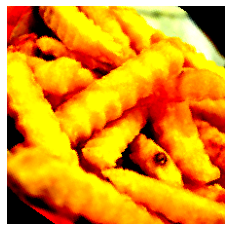

In [ ]:
print(train[0][1])
plt.imshow(train[0][0].squeeze().permute(1,2,0))
plt.axis('off')
plt.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size=50, )
val_loader = torch.utils.data.DataLoader(val, batch_size=50, )
test_loader = torch.utils.data.DataLoader(test, batch_size=50)

## Train and Test Fuctions

In [ ]:
def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu", PATH='/tmp/checkpoint'):
  model = model.to(device)
  history = []
  max_acc = 0
  for epoch in range(1, epochs+1):
    training_loss = 0.0
    valid_loss = 0.0
    num_correct = 0 
    num_examples = 0
    model.train()

    start_time = time.time()
    for batch in train_loader:
      optimizer.zero_grad()
      inputs, targets = batch
      inputs = inputs.to(device)
      targets = targets.to(device)
      output = model(inputs)  
      loss = loss_fn(output, targets)
      loss.backward()
      optimizer.step()

      training_loss += loss.data.item() * inputs.size(0)
      correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1],
                         targets)
      num_correct += torch.sum(correct).item()
      num_examples += correct.shape[0]

    train_time = time.time() - start_time
    training_loss /= len(train_loader.dataset)
    train_acc = num_correct / num_examples

    model.eval()
    num_correct = 0 
    num_examples = 0

    start_time = time.time()
    for batch in val_loader:
      inputs, targets = batch
      inputs = inputs.to(device)
      output = model(inputs)
      targets = targets.to(device)
      loss = loss_fn(output,targets) 

      valid_loss += loss.data.item() * inputs.size(0)
      correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1],
                          targets)
      num_correct += torch.sum(correct).item()
      num_examples += correct.shape[0]

    val_time = time.time() - start_time
    valid_loss /= len(val_loader.dataset)
    val_acc = num_correct / num_examples

    if val_acc > max_acc:
      max_acc = val_acc
      torch.save(model.state_dict(), PATH)

    history.append((training_loss, valid_loss, train_acc, val_acc, train_time, val_time))
    print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, Training accuracy = {:.2f}, Test accuracy = {:.2f}, train_time = {:.2f}, test_time = {:.2f} '.format(epoch, training_loss,
    valid_loss, train_acc, val_acc, train_time, val_time))
    
  return history

In [ ]:
def test_model(model, loss_fn, test_loader, device="cpu"):
  model = model.to(device)
  model.eval()
  num_correct = 0 
  num_examples = 0
  test_loss = 0.0
  start_time = time.time()
  for batch in test_loader:
    inputs, targets = batch
    inputs = inputs.to(device)
    output = model(inputs)
    targets = targets.to(device)
    loss = loss_fn(output, targets) 
    test_loss += loss.data.item() * inputs.size(0)
    correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1],
                        targets)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]

  test_time = time.time() - start_time
  test_loss /= len(test_loader.dataset)

  print('accuracy = {:.2f}, test_time = {:.2f} '.format(num_correct / num_examples, test_time))

In [ ]:
def plot_history(history):
  df_res_ = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Test Loss', 'Test Acc'])
  df_res_['Train Loss'] = [i[0] for i in history]
  df_res_['Test Loss'] = [i[1] for i in history]
  df_res_['Train Acc'] = [i[2] for i in history]
  df_res_['Test Acc'] = [i[3] for i in history]
  df_res_['Train Time'] = [i[4] for i in history]
  df_res_['Test Time'] = [i[5] for i in history]
  df_res_['Epoch'] = range(1, len(history)+1)

  df_res_[['Train Acc', 'Test Acc']][1:].plot(title='Accuracy history')
  df_res_[['Train Loss', 'Test Loss']][1:].plot(title='Loss history');

## Simple Convolution Neural Network

Before using large pretrained models, let's use a simple convolution network as a baseline model.

In [ ]:
PATH='/tmp/checkpoint'

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(          
            nn.Conv2d(3, 64, kernel_size=5),
            nn.Conv2d(64, 32, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=3),
        )
        self.fconnected = nn.Sequential(
            nn.Dropout(),
            nn.LazyLinear(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fconnected(x)
        return x

In [ ]:
model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
history_values = train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs=40, device='cuda')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 1, Training Loss: 0.84, Validation Loss: 0.72, Training accuracy = 0.62, Test accuracy = 0.51, train_time = 9.15, test_time = 1.20 
Epoch: 2, Training Loss: 0.68, Validation Loss: 0.83, Training accuracy = 0.69, Test accuracy = 0.55, train_time = 9.06, test_time = 1.20 
Epoch: 3, Training Loss: 0.77, Validation Loss: 0.86, Training accuracy = 0.63, Test accuracy = 0.54, train_time = 9.08, test_time = 1.17 
Epoch: 4, Training Loss: 0.68, Validation Loss: 0.91, Training accuracy = 0.68, Test accuracy = 0.56, train_time = 8.91, test_time = 1.16 
Epoch: 5, Training Loss: 0.55, Validation Loss: 0.72, Training accuracy = 0.76, Test accuracy = 0.60, train_time = 9.05, test_time = 1.19 
Epoch: 6, Training Loss: 0.47, Validation Loss: 0.77, Training accuracy = 0.80, Test accuracy = 0.62, train_time = 9.17, test_time = 1.21 
Epoch: 7, Training Loss: 0.43, Validation Loss: 0.79, Training accuracy = 0.79, Test accuracy = 0.64, train_time = 8.98, test_time = 1.18 
Epoch: 8, Training Loss: 0.

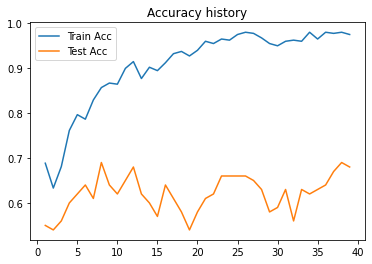

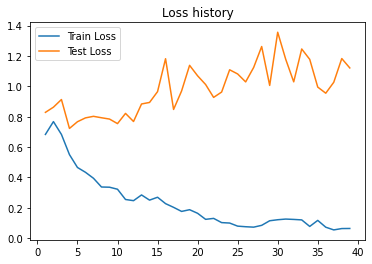

In [ ]:
plot_history(history_values)

In [ ]:
test_model(model, loss_fn, test_loader, )

accuracy = 0.61, test_time = 54.36 


In [ ]:
best_model = CNN()
best_model.load_state_dict(torch.load(PATH))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [ ]:
test_model(best_model, loss_fn, test_loader, )

accuracy = 0.65, test_time = 53.33 


We can see, that the model significantly overfitted. Accuracy almost didn't rise, loss rose.

## Pre-trained model

Let's try to use pretrained model. We will disable gradient in main layers, despite BatchNormalization.

In [ ]:
from torchvision import models
transfer_model = models.resnet50(pretrained=True)

for name, param in transfer_model.named_parameters():
  if("bn" not in name):
    param.requires_grad = False

transfer_model.fc = nn.Sequential(
    nn.Linear(transfer_model.fc.in_features, 512), 
    nn.ReLU(),
    nn.Dropout(), 
    nn.Linear(512, 2)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transfer_model.parameters(), lr=0.0001)

In [ ]:
history_values1 = train_model(transfer_model, optimizer, loss_fn, train_loader, val_loader, epochs=50, device='cuda')

Epoch: 1, Training Loss: 0.69, Validation Loss: 0.61, Training accuracy = 0.54, Test accuracy = 0.77, train_time = 10.93, test_time = 1.74 
Epoch: 2, Training Loss: 0.62, Validation Loss: 0.57, Training accuracy = 0.73, Test accuracy = 0.83, train_time = 10.99, test_time = 1.70 
Epoch: 3, Training Loss: 0.55, Validation Loss: 0.53, Training accuracy = 0.81, Test accuracy = 0.86, train_time = 10.87, test_time = 1.76 
Epoch: 4, Training Loss: 0.51, Validation Loss: 0.48, Training accuracy = 0.83, Test accuracy = 0.89, train_time = 10.53, test_time = 1.60 
Epoch: 5, Training Loss: 0.45, Validation Loss: 0.44, Training accuracy = 0.84, Test accuracy = 0.89, train_time = 10.53, test_time = 1.67 
Epoch: 6, Training Loss: 0.42, Validation Loss: 0.40, Training accuracy = 0.86, Test accuracy = 0.92, train_time = 10.56, test_time = 1.66 
Epoch: 7, Training Loss: 0.37, Validation Loss: 0.37, Training accuracy = 0.88, Test accuracy = 0.92, train_time = 10.49, test_time = 1.58 
Epoch: 8, Training L

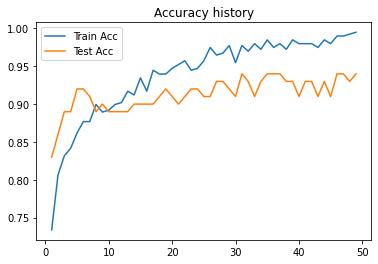

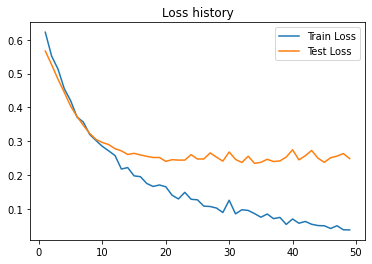

In [ ]:
plot_history(history_values1)

In [ ]:
test_model(transfer_model, loss_fn, test_loader, device='cuda')

accuracy = 0.89, test_time = 7.72 


In [ ]:
transfer_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
test_model(transfer_model, loss_fn, test_loader, device='cuda')

accuracy = 0.90, test_time = 7.67 


We can see overfitting, but not so significant, as previous NN showed. Accuracy is about 0.9.

## Un-freezed layers

In [ ]:
transfer_model = models.resnet50(pretrained=True)

for name, param in transfer_model.named_parameters():
    param.requires_grad = True

transfer_model.fc = nn.Sequential(
    nn.Linear(transfer_model.fc.in_features, 512), 
    nn.ReLU(),
    nn.Dropout(), 
    nn.Linear(512, 2)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transfer_model.parameters(), lr=0.00001)

In [ ]:
history_values2 = train_model(transfer_model, optimizer, loss_fn, train_loader, val_loader, epochs=30, device='cuda')

Epoch: 1, Training Loss: 0.70, Validation Loss: 0.68, Training accuracy = 0.52, Test accuracy = 0.66, train_time = 12.63, test_time = 1.52 
Epoch: 2, Training Loss: 0.67, Validation Loss: 0.65, Training accuracy = 0.61, Test accuracy = 0.80, train_time = 12.53, test_time = 1.53 
Epoch: 3, Training Loss: 0.63, Validation Loss: 0.63, Training accuracy = 0.72, Test accuracy = 0.87, train_time = 12.54, test_time = 1.54 
Epoch: 4, Training Loss: 0.60, Validation Loss: 0.60, Training accuracy = 0.79, Test accuracy = 0.87, train_time = 12.52, test_time = 1.54 
Epoch: 5, Training Loss: 0.56, Validation Loss: 0.57, Training accuracy = 0.85, Test accuracy = 0.89, train_time = 12.61, test_time = 1.55 
Epoch: 6, Training Loss: 0.53, Validation Loss: 0.54, Training accuracy = 0.86, Test accuracy = 0.90, train_time = 12.64, test_time = 1.56 
Epoch: 7, Training Loss: 0.49, Validation Loss: 0.50, Training accuracy = 0.88, Test accuracy = 0.92, train_time = 12.64, test_time = 1.57 
Epoch: 8, Training L

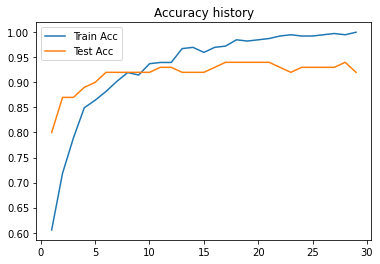

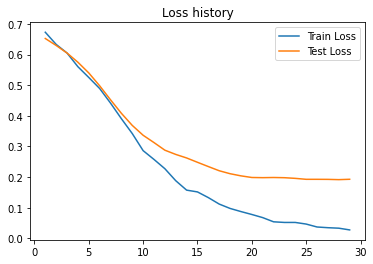

In [ ]:
plot_history(history_values2)

In [ ]:
test_model(transfer_model, loss_fn, test_loader, device='cuda')

accuracy = 0.91, test_time = 8.52 


In [ ]:
transfer_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
test_model(transfer_model, loss_fn, test_loader, device='cuda')

accuracy = 0.92, test_time = 8.62 


Some insights:

* Model with enabled gradients showed better results, but trained slower. But this can be the result of randomness of NN.

* Pre-trained models started with underfitting (Test accuracy > Train accuracy), and after that overfitted.

Conclusion:

NN worked good for classical task of machine learning. But it has some problems: poor interpretability and randomness. NNs built on Gradient Descent, so the results depend on start weights. And there is almost no way to interprete the recieved complex structure of NN. 

So, we can claim, that Neural Networks are best suited to deal with complicated tasks, like Image Classification, Object Detection and so on.